In [1]:
# BLOQUE 1 ‚Äî Cargar AOI

import geopandas as gpd

# Leer el geojson
aoi = gpd.read_file('../data/geojson/campo-bruzo.geojson')


In [2]:
# BLOQUE 2 ‚Äî Mostrar AOI en mapa interactivo (m√°s zoomado)

import geemap.foliumap as geemap
import json

# 1. Reproyectar AOI a Web-Mercator (3857) ‚Äî lo que usan los mapas web
aoi_proj = aoi.to_crs(epsg=3857)

# 2. Centro en lat/lon (4326) para inicializar el mapa
center = [
    aoi_proj.to_crs(epsg=4326).geometry.centroid.y.mean(),
    aoi_proj.to_crs(epsg=4326).geometry.centroid.x.mean()
]

# 3. Crear mapa con zoom m√°s cercano (por ej. 15)
m = geemap.Map(center=center, zoom=15)

geojson_dict = json.loads(aoi.to_json())
m.add_geojson(geojson_dict, layer_name='AOI')

bounds = aoi_proj.to_crs(epsg=4326).total_bounds  # [minx, miny, maxx, maxy]
m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

# 6. Mostrar mapa
m


/Users/chrisijjas/Desktop/itba/satellite-image-processing/sat/lib/python3.13/site-packages/geemap/conversion.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/3530808338.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  aoi_proj.to_crs(epsg=4326).geometry.centroid.y.mean(),
/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/3530808338.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  aoi_proj.to_crs(epsg=432

In [4]:
# BLOQUE 3 ‚Äî Descargar autom√°ticamente la √∫ltima imagen de Sentinel-2 y exportar TODAS las bandas necesarias

import geemap, ee
from datetime import date

# 1. Conectarse a Google Earth Engine (solo la primera vez pide el token)
ee.Authenticate()
ee.Initialize()

# 2. Convertir AOI (GeoDataFrame) a FeatureCollection / Geometry de GEE
aoi_fc   = geemap.geopandas_to_ee(aoi)
aoi_geom = aoi_fc.geometry()

# 3. Definir rango temporal: desde 2024-01-01 hasta HOY
today = date.today().strftime("%Y-%m-%d")

collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(aoi_geom)
    .filterDate("2024-01-01", today)
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5))   # ‚â§5 % nubes
    .sort("system:time_start", False)                     # m√°s reciente primero
)

latest = collection.first()
print("√öltima imagen:", latest.date().format("YYYY-MM-dd").getInfo())

# 4. Bandas a exportar  (nombre ‚Üí archivo de salida)
bands = {
    "B2" : "B2.tif",   # Blue
    "B3" : "B3.tif",   # Green
    "B4" : "B4.tif",   # Red
    "B5" : "B5.tif",   # Red-Edge 1 (705 nm)
    "B8" : "B8.tif",   # NIR 10 m
    "B8A": "B8A.tif",  # Red-Edge 4 / Narrow‚ÄêNIR (865 nm)
    "B11": "B11.tif",  # SWIR1
    "B12": "B12.tif",  # SWIR2
}

# 5. Resoluci√≥n por banda (m).  GEE re-muestra autom√°ticamente.
scale = {
    "B2": 10, "B3": 10, "B4": 10,
    "B5": 20,           # red-edge 20 m
    "B8": 10,
    "B8A": 20,  # red-edge 20 m
    "B11": 20, "B12": 20,
    
}

# 6. Exportar cada banda recortada al AOI
for b, out_name in bands.items():
    print(f"   ‚ûú exportando {b}  ‚Üí  {out_name}  ({scale[b]} m)")
    geemap.ee_export_image(
        latest.select(b),
        filename=f"../data/sentinel2/{out_name}",
        scale=scale[b],
        region=aoi_geom
    )


√öltima imagen: 2025-06-01
   ‚ûú exportando B2  ‚Üí  B2.tif  (10 m)
Generating URL ...
Please wait ...
Data downloaded to /Users/chrisijjas/Desktop/itba/satellite-image-processing/data/sentinel2/B2.tif
   ‚ûú exportando B3  ‚Üí  B3.tif  (10 m)
Generating URL ...
Please wait ...
Data downloaded to /Users/chrisijjas/Desktop/itba/satellite-image-processing/data/sentinel2/B3.tif
   ‚ûú exportando B4  ‚Üí  B4.tif  (10 m)
Generating URL ...
Please wait ...
Data downloaded to /Users/chrisijjas/Desktop/itba/satellite-image-processing/data/sentinel2/B4.tif
   ‚ûú exportando B5  ‚Üí  B5.tif  (20 m)
Generating URL ...
Please wait ...
Data downloaded to /Users/chrisijjas/Desktop/itba/satellite-image-processing/data/sentinel2/B5.tif
   ‚ûú exportando B8  ‚Üí  B8.tif  (10 m)
Generating URL ...
Please wait ...
Data downloaded to /Users/chrisijjas/Desktop/itba/satellite-image-processing/data/sentinel2/B8.tif
   ‚ûú exportando B8A  ‚Üí  B8A.tif  (20 m)
Generating URL ...
Please wait ...
Data downloade

In [5]:
# BLOQUE 4 ‚Äî Leer TODAS las bandas Sentinel-2 y recortarlas al AOI

import rasterio
import rasterio.mask
from shapely.geometry import mapping

# ---------- Funci√≥n gen√©rica ----------
def read_band_crop(path_band, aoi_gdf):
    """Lee un raster, reproyecta el AOI al CRS del raster y devuelve el array recortado + metadata."""
    with rasterio.open(path_band) as src:
        raster_crs = src.crs
        aoi_proj   = aoi_gdf.to_crs(raster_crs)                   # reproyectar AOI
        out_img, _ = rasterio.mask.mask(src,
                                        aoi_proj.geometry.apply(mapping),
                                        crop=True)
        return out_img[0], src.meta                               # s√≥lo la 1.¬™ banda, metadata intacta

# ---------- Rutas a cada banda ----------
paths = {
    "B2" : "../data/sentinel2/B2.tif",   # Blue   (10 m)
    "B3" : "../data/sentinel2/B3.tif",   # Green  (10 m)
    "B4" : "../data/sentinel2/B4.tif",   # Red    (10 m)
    "B5" : "../data/sentinel2/B5.tif",   # Red-Edge 1 (20 m)
    "B8" : "../data/sentinel2/B8.tif",   # NIR    (10 m)
    "B8A": "../data/sentinel2/B8A.tif",  # Red-Edge 4 / Narrow NIR (20 m)
    "B11": "../data/sentinel2/B11.tif",  # SWIR1  (20 m)
    "B12": "../data/sentinel2/B12.tif",  # SWIR2  (20 m)
}

# ---------- Leer todas las bandas ----------
bands = {}
for bn, p in paths.items():
    arr, meta = read_band_crop(p, aoi)
    bands[bn] = arr.astype("float32")    # guardamos como float32 para c√°lculos posteriores

# Podemos tomar la metadata de una banda de 10 m (B4) como referencia para guardar resultados
meta_ref = meta

# Ejemplo de acceso:
blue_band  = bands["B2"]
green_band = bands["B3"]
red_band   = bands["B4"]
rededge_b5 = bands["B5"]
nir_band   = bands["B8"]
narrow_nir = bands["B8A"]
swir1      = bands["B11"]
swir2      = bands["B12"]

print("Bandas recortadas y listas:",
      ", ".join(bands.keys()))


Bandas recortadas y listas: B2, B3, B4, B5, B8, B8A, B11, B12


/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/531061714.py:5: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir_band - red_band) / (nir_band + red_band)


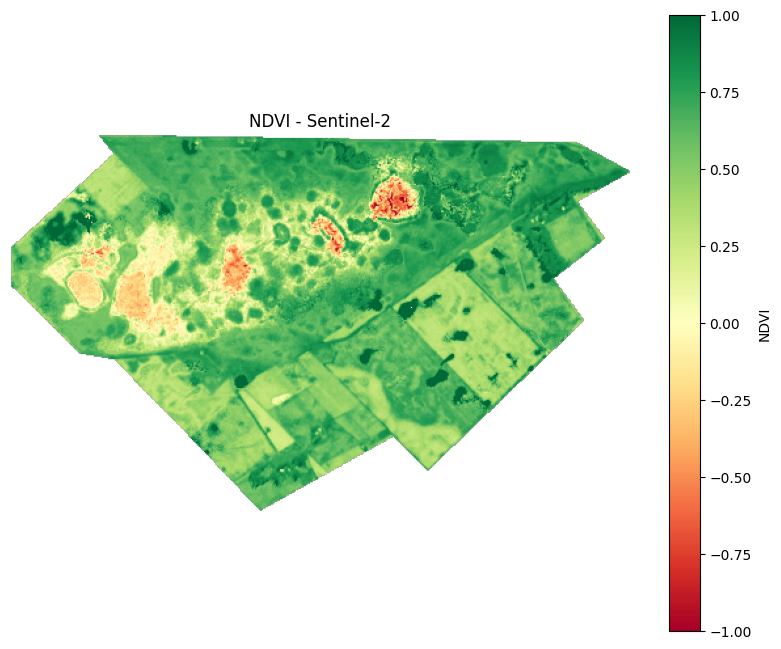

In [ ]:
from matplotlib import pyplot as plt
# BLOQUE 6A ‚Äî Calcular NDVI, Mostrar NDVI
# Vegetaci√≥n general (sanidad, biomasa)

ndvi = (nir_band - red_band) / (nir_band + red_band)

plt.figure(figsize=(10,8))
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI - Sentinel-2')
plt.axis('off')
plt.show()


In [ ]:
# BLOQUE 7 ‚Äî Crear video de NDVI en el tiempo y mostrarlo (versi√≥n robusta con cache de frames)

from datetime import datetime
import numpy as np
import imageio.v3 as iio  # usar imageio v3 API
import os
from matplotlib import pyplot as plt
from IPython.display import Video, display

# 1. A√±adir banda NDVI a la colecci√≥n
def calc_ndvi(img):
    ndvi = img.normalizedDifference(["B8", "B4"]).rename("NDVI")
    return img.addBands(ndvi)

ndvi_collection = collection.map(calc_ndvi).sort("system:time_start", True)


# 2. Obtener lista de im√°genes y fechas
n_images = ndvi_collection.size().getInfo()
print(f"Total im√°genes en la colecci√≥n: {n_images}")

image_list = ndvi_collection.toList(n_images)

# Obtener fechas (como strings YYYY-MM-DD)
date_strings = ndvi_collection.aggregate_array("system:time_start").map(
    lambda t: ee.Date(t).format("YYYY-MM-dd")
).getInfo()

# Convertir a formato bonito "15 MAY 2025"
dates = []
for ds in date_strings:
    dt = datetime.strptime(ds, "%Y-%m-%d")
    dates.append(dt.strftime("%d %b %Y").upper())
    
# 3. Crear carpeta para los frames
os.makedirs("../output/ndvi_frames", exist_ok=True)

# 4. Generar frames de NDVI (skip existing PNGs)
frame_paths = []

for i in range(n_images):
    frame_path = f"../output/ndvi_frames/frame_{i:03d}.png"
    frame_paths.append(frame_path)
    
    if os.path.exists(frame_path):
        print(f"üü¢ Frame {i+1}/{n_images} ({dates[i]}) ya existe, usando cache.")
        continue
    
    print(f"‚öôÔ∏è  Procesando imagen {i+1}/{n_images} ({dates[i]})...")
    
    img = ee.Image(image_list.get(i))
    ndvi_band = img.select("NDVI")
    
    # Convertir a numpy array (usar resoluci√≥n alta para video)
    ndvi_array = geemap.ee_to_numpy(ndvi_band, region=aoi_geom, scale=10)
    
    # Plot en matplotlib
    fig, ax = plt.subplots(figsize=(8,6))
    cax = ax.imshow(ndvi_array.squeeze(), cmap='RdYlGn', vmin=-1, vmax=1)
    ax.set_title(f"NDVI - {dates[i]}")
    ax.axis('off')
    fig.colorbar(cax, ax=ax, label='NDVI')

    # Guardar el frame como PNG
    plt.savefig(frame_path)
    plt.close(fig)

# 5. Guardar como video MP4 usando imageio v3
video_path = "../output/ndvi_timelapse.mp4"

# Leer los frames como im√°genes
frame_images = [iio.imread(fp) for fp in frame_paths]

# Escribir video con codec h264 (libx264)
iio.imwrite(video_path, frame_images, fps=2, codec='libx264')

print(f"\n‚úÖ Video guardado: {video_path}")

# 6. Mostrar el video en la notebook
display(Video(video_path, embed=True))


Total im√°genes en la colecci√≥n: 55
‚öôÔ∏è  Procesando imagen 1/55 (23 JAN 2024)...
‚öôÔ∏è  Procesando imagen 2/55 (23 JAN 2024)...
‚öôÔ∏è  Procesando imagen 3/55 (28 JAN 2024)...
‚öôÔ∏è  Procesando imagen 4/55 (28 JAN 2024)...
‚öôÔ∏è  Procesando imagen 5/55 (28 MAR 2024)...
‚öôÔ∏è  Procesando imagen 6/55 (17 APR 2024)...
‚öôÔ∏è  Procesando imagen 7/55 (17 APR 2024)...
‚öôÔ∏è  Procesando imagen 8/55 (02 MAY 2024)...
‚öôÔ∏è  Procesando imagen 9/55 (02 MAY 2024)...
‚öôÔ∏è  Procesando imagen 10/55 (01 JUN 2024)...
‚öôÔ∏è  Procesando imagen 11/55 (11 JUL 2024)...
‚öôÔ∏è  Procesando imagen 12/55 (11 JUL 2024)...
‚öôÔ∏è  Procesando imagen 13/55 (26 JUL 2024)...
‚öôÔ∏è  Procesando imagen 14/55 (26 JUL 2024)...
‚öôÔ∏è  Procesando imagen 15/55 (25 AUG 2024)...
‚öôÔ∏è  Procesando imagen 16/55 (04 SEP 2024)...
‚öôÔ∏è  Procesando imagen 17/55 (04 SEP 2024)...
‚öôÔ∏è  Procesando imagen 18/55 (14 SEP 2024)...
‚öôÔ∏è  Procesando imagen 19/55 (14 SEP 2024)...
‚öôÔ∏è  Procesando imagen 20/55 (19 OCT 2

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (961, 743) to (976, 752) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x148e12c10] Stream #0: not enough frames to estimate rate; consider increasing probesize



‚úÖ Video guardado: ../output/ndvi_timelapse.mp4 (55 frames, 27.5 seconds)


/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/4115668954.py:3: RuntimeWarning: invalid value encountered in divide
  ndre = (narrow_nir - rededge_b5) / (narrow_nir + rededge_b5)


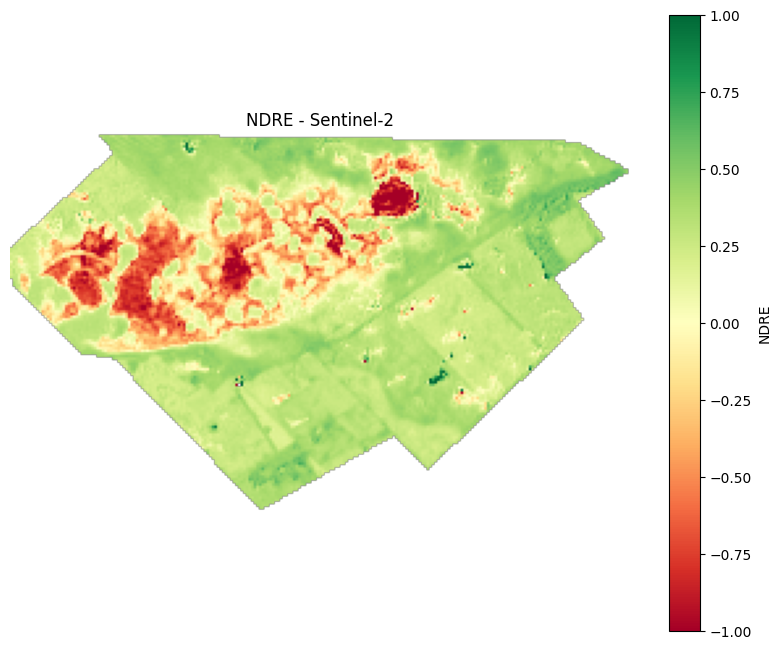

In [8]:
# BLOQUE 6B ‚Äî Calcular NDRE, Mostrar NDRE
# Clorofila en cultivos densos (frutilla, repollo)
ndre = (narrow_nir - rededge_b5) / (narrow_nir + rededge_b5)

plt.figure(figsize=(10,8))
plt.imshow(ndre, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NDRE')
plt.title('NDRE - Sentinel-2')
plt.axis('off')
plt.show()


/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/3298642917.py:4: RuntimeWarning: divide by zero encountered in divide
  cire = (narrow_nir / rededge_b5) - 1
/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/3298642917.py:4: RuntimeWarning: invalid value encountered in divide
  cire = (narrow_nir / rededge_b5) - 1


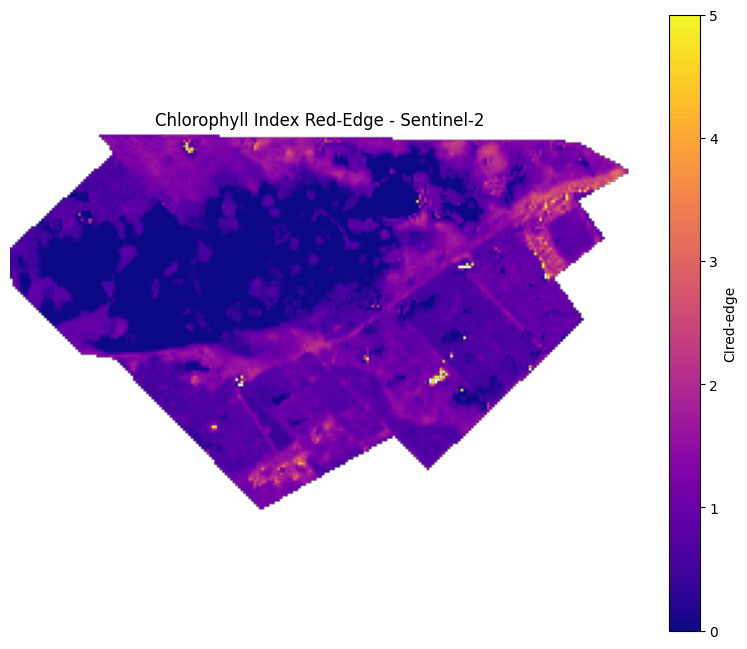

In [9]:
# BLOQUE 6C ‚Äî Calcular CIred-edge, Mostrar CIred-edge
# Contenido de clorofila (diagn√≥stico nutricional)

cire = (narrow_nir / rededge_b5) - 1

plt.figure(figsize=(10,8))
plt.imshow(cire, cmap='plasma', vmin=0, vmax=5)
plt.colorbar(label='CIred-edge')
plt.title('Chlorophyll Index Red-Edge - Sentinel-2')
plt.axis('off')
plt.show()


/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/1249998680.py:7: RuntimeWarning: invalid value encountered in divide
  ndwi = (nir_band - swir1_resampled) / (nir_band + swir1_resampled)


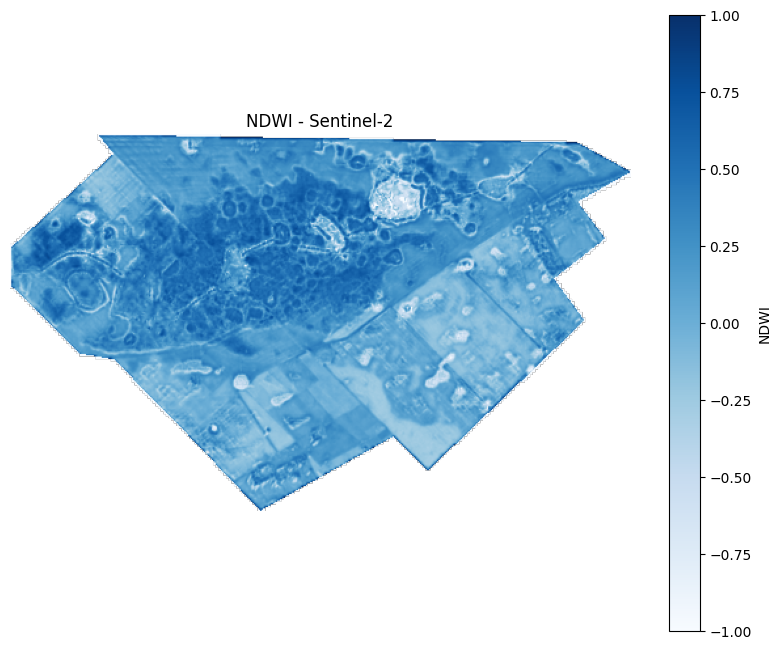

In [10]:
# BLOQUE 6D ‚Äî Calcular NDWI, Mostrar NDWI (con resize r√°pido)

from skimage.transform import resize

swir1_resampled = resize(swir1, nir_band.shape, preserve_range=True)

ndwi = (nir_band - swir1_resampled) / (nir_band + swir1_resampled)

plt.figure(figsize=(10,8))
plt.imshow(ndwi, cmap='Blues', vmin=-1, vmax=1)
plt.colorbar(label='NDWI')
plt.title('NDWI - Sentinel-2')
plt.axis('off')
plt.show()


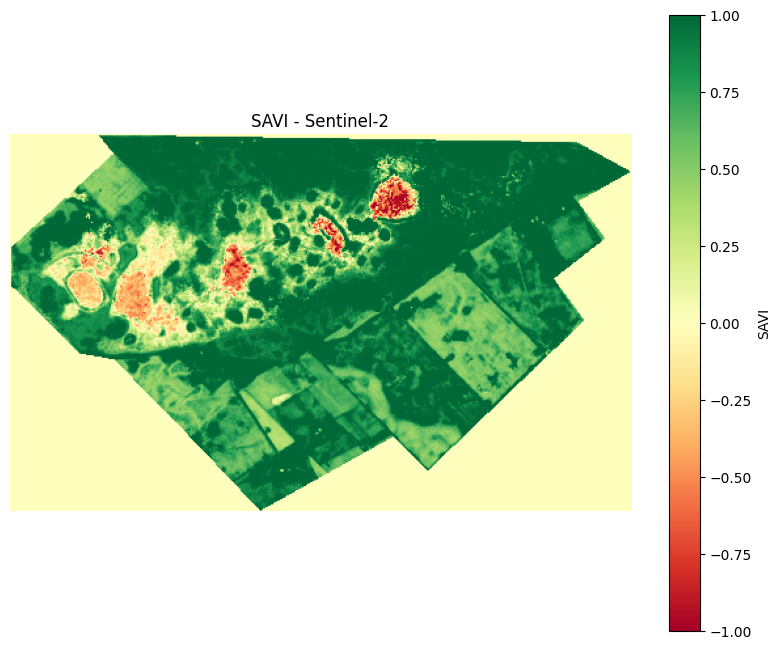

In [11]:
# BLOQUE 6E ‚Äî Calcular SAVI, Mostrar SAVI
# Vegetaci√≥n en estadios tempranos (mucho suelo visible)
savi = (1.5 * (nir_band - red_band)) / (nir_band + red_band + 0.5)

plt.figure(figsize=(10,8))
plt.imshow(savi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='SAVI')
plt.title('SAVI - Sentinel-2')
plt.axis('off')
plt.show()


/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/914114995.py:3: RuntimeWarning: divide by zero encountered in divide
  psri = (red_band - green_band) / nir_band
/var/folders/l4/ff00d3291fx5ftpwr9rtx8g40000gn/T/ipykernel_39083/914114995.py:3: RuntimeWarning: invalid value encountered in divide
  psri = (red_band - green_band) / nir_band


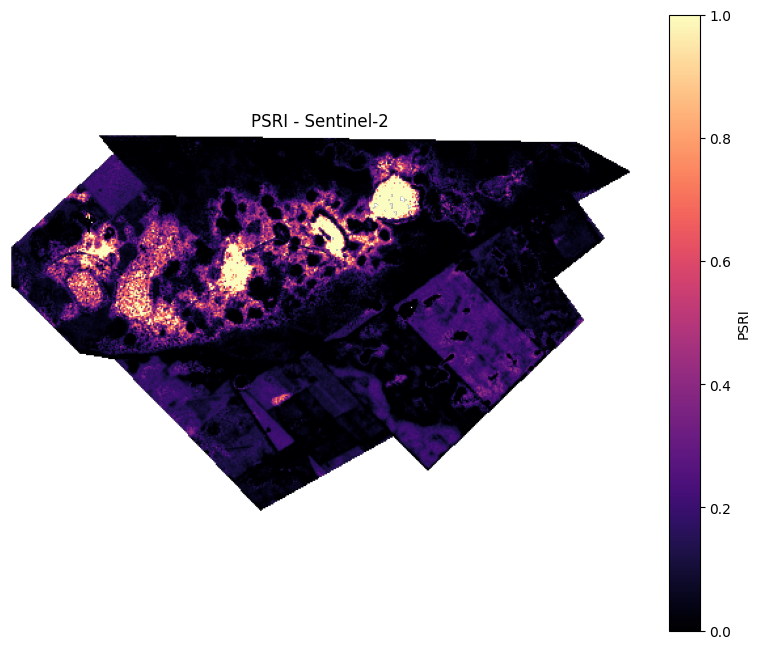

In [12]:
# BLOQUE 6F ‚Äî Calcular PSRI, Mostrar PSRI
# Senescencia, maduraci√≥n, inicio de cosecha
psri = (red_band - green_band) / nir_band

plt.figure(figsize=(10,8))
plt.imshow(psri, cmap='magma', vmin=0, vmax=1)
plt.colorbar(label='PSRI')
plt.title('PSRI - Sentinel-2')
plt.axis('off')
plt.show()
